In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

##############
# PATH
##############
path_comune = '/content/drive/MyDrive/Giordano_Controls/' # CHECK se serve cambiarlo
%cd drive/MyDrive/Giordano_Controls/Dataset/dati_puliti/ibrido/prova_resampled/
!pip install numpy matplotlib pandas scikit-learn seaborn torch
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
df = pd.read_csv('final_freq_res_19.csv', low_memory=False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
anomaly_detection = True
pred_maint = False


Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1jMiJZ40Vwym_u4NEJoLcqoWgJT0x3Y0t/Giordano_Controls/Dataset/dati_puliti/ibrido/prova_resampled
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

# Feature selection

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
#df = pd.read_csv( "insert your .csv")
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
#non_numeric_cols = data_df.select_dtypes(exclude=['float64', 'int64']).columns

non_numeric_cols = ['heater', 'vt', 'code']

# 3) (Optional) Exclude columns you don’t want to transform (e.g., target, IDs)
numeric_cols = [col for col in numeric_cols if col not in ["heater", "vt", 'code', 'maint']] #la possiamo lasciare commentata perche entrambi sono non numerici

# 4) Scale the numeric columns
# TODO!! fIX scaling
# self._cts = CTS(df= None,
#             anomaly_detection= self.anomaly_detection,
#             pred_maint= self.pred_maint,
#             verbose= self.verbose) #TODO:se servono dynamic windowing parameters

# scaled_data = self._cts.scaling(dataFrame= data_df)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numeric_cols])

# 5) Fit PCA with 90% variance explained
pca = PCA(n_components=0.9)  # keeps enough components to explain 90% of the variance, we can also set a fixed number of components and comment the line 100
pca_data = pca.fit_transform(scaled_data)

# We won’t know exactly how many components this results in until after fitting,
# so we get that number from the PCA object
num_components = pca_data.shape[1]
print(num_components)


In [ ]:
# Create column names for the principal components
pca_columns = [f'PC_{i+1}' for i in range(num_components)]

df_pca = pd.DataFrame(pca_data, columns=pca.get_feature_names_out(), index=df.index)

# 6) Concatenate the non-numeric columns (if you want to keep them) and the PCA columns
df_pca_39 = pd.concat([df[non_numeric_cols], df_pca], axis=1)
#TODO: dovrebbe funzionare, ma nel dataset resampled manca la colonna 'code'

#df_pca_9 = pd.concat([df_pca_9, data_df['code']], axis=1)

# Frequency resampling

In [ ]:
import numpy as np
def _relevant_frequency2(df, harmonics):
    """
    Computes the most relevant frequency

    Args:
        df (pd.DataFrame): The DataFrame to analize
        harmonics (int): frequencies to account for

    Returns:
        float: relevant frequency
    """
    frequencies = []
    for index in range(np.shape(df.values)[1]):
        # Exclude the 'vt' and other non-numeric columns
        if df.columns[index] not in ['vt', 'heater', 'code'] and any([el for el in df.values[:,index] if (isinstance(el, (int, float, complex)) and int(el)!=el) ]): #consider frequencies of continuous variables
            w = np.fft.fft(df.values[:,index])
            freqs = np.fft.fftfreq(len(w))
            mods = abs(w)
            max_indices = np.argsort(mods)[::-1][:harmonics]
            main_freq = freqs[max_indices]
            frequencies.extend(main_freq)

    #select most relevant frequencies between all TS(top 5%)
    sorted = np.sort([el for el in frequencies if el>0])[::-1]
    max_freq= 1
    for freq in sorted:
        if len([fr for fr in sorted if fr < freq]) / len(sorted) < 0.95:
            max_freq = freq
            break


    print("relevant frequency done!")
    return max_freq

In [ ]:
def _frequency_resampling_pipeline2(df, harmonics):
    # Compute main frequencies for each TS(column)
    max_freq = _relevant_frequency2(df, harmonics)

    # Downsampling based on relevant frequency
    res_freq = max(1, int(np.floor(1 / 10 / max_freq)))
    downsamp = df.iloc[::res_freq, :]

    # Compute diff only on numeric columns to avoid subtracting strings
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    diff_mask = df[numeric_cols].diff().ne(0).any(axis=1)

    # Determine the condition based on available flags
    if anomaly_detection:
        condition = diff_mask | (df["code"] == 1)
    elif pred_maint:
        condition = diff_mask | (df["maint"] == 1)
    else:
        condition = diff_mask

    # Retain rows showing evolution based on the condition
    df = df.loc[condition].copy()

    # Drop redundant timestamps from one dataframe
    df = df.drop(index=df.index.intersection(downsamp.index))

    # Rebuild dataframe
    df = pd.concat([df, downsamp])

    return df


In [ ]:
#optimized
def frequency_resampling3(df: pd.DataFrame, harmonics: int = 5, grouper_freq: str = None, verbose: bool = False):
    """
    Resamples the DataFrame after a frequency analysis based on the first N harmonics

    Args:
        df (pd.DataFrame):
            The DataFrame to analyze
        harmonics (int):
            Frequencies to account for
        grouper_freq (str):
            The string representing the time slice used for the frequency analysis.
            For available values: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
            Ex. freq= "D" creates N (number of days) dataframes,
            automatically dividing the less-specific intervals (D->Y, M, D, min->Y, M, D, H, min)
        verbose (bool):
            Enable terminal messages

    Returns:
        pd.DataFrame: The resampled DataFrame
    """

    if verbose:
        print(f"Heater dataframes will be sliced based on the given value {grouper_freq}")

    final_df = pd.DataFrame()


    # Group by 'heater'
    for heater, group in df.groupby("heater"):
        # Drop the original heater column (we will reassign it later)
        #df_red = group.drop(columns="heater")

        if verbose:
            print(f"Resampling heater {heater}...")

        # Convert all columns (except 'vt', 'heater', 'code') to numeric, coercing errors to NaN
        #numeric_cols = [col for col in df_red.columns if col not in ['vt', 'heater', 'code']]
        #df_red[numeric_cols] = df_red[numeric_cols].apply(pd.to_numeric, errors='coerce')

        #df_red = _frequency_resampling_pipeline(df_red, harmonics).sort_index()

        final_df = pd.concat([final_df,
                              _frequency_resampling_pipeline(group,
                                                             harmonics).sort_index()])
        print("concat fatto ", heater)
        # Instead of inserting the 'heater' column one at a time,
        # store the processed DataFrame in a dict using the heater as key.

    # Concatenate all processed DataFrames at once using the keys parameter.
    # This creates a MultiIndex with the heater values.

    # If you prefer to have 'heater' as a regular column rather than an index:
    #final_df = final_df.reset_index("heater")

    if verbose:
        print("Resampling finished!")

    return final_df


In [ ]:
df_resampling = frequency_resampling3(df)

# functions

In [ ]:
def create_windowed_dataset(df:pd.DataFrame = None, keep_vt = False, keep_heater = False, keep_code = False):
    """
    Prepares the dataset for single-step time-series forecasting by creating sequences of input features (xRes)
    and corresponding target values (yRes).

    Args:
        df (pd.DataFrame, optional): The input DataFrame. If not provided, the function will use self.df.
        keep_vt(bool):
        keep_heater(bool):
    Returns:
        tuple: A tuple containing two numpy arrays:
            - xRes (np.ndarray): The input features for time-series forecasting.
            - yRes (np.ndarray): The target values for time-series forecasting.

        :return: List of (X, Y) windows.
    """


    xRes = []
    yRes = []
    grouped = df.groupby('heater')
    win_size = "1D"
    future_sight= "7D"

    for heater, group in grouped:

        #ensure data format is correct
        group["vt"] = pd.to_datetime(group["vt"], format='ISO8601')
        group["vt"] = pd.to_datetime(group["vt"], format='mixed')

        group.sort_values(by="vt", inplace=True)

        # valori di windowing
        #Per info sui formati: https://pandas.pydata.org/docs/user_guide/timedeltas.html
        #dobbiamo cambiare self.len in formati tipo '7D'/'1H'/...
        # solo self.len_pred_step:int(penso abbia senso saltare in proporzione a X/k, sennò rischiamo troppi dati)
        x_T = pd.Timedelta(win_size) # Xs temporal size
        shift = pd.Timedelta(win_size) * .3  # fraction of X size as step
        y_T = pd.Timedelta(win_size) # Ys temporal size
        future = pd.Timedelta(future_sight) # prediction distance

        start_time = group["vt"].min().to_numpy()
        end_time = group["vt"].max().to_numpy()

        #Non ho idea di come FORarlo
        while start_time + future+ y_T <= end_time:
            start_idx = np.searchsorted(group["vt"].values, np.datetime64(start_time), side="left")
            end_idx = np.searchsorted(group["vt"].values, np.datetime64(start_time + x_T), side="left")
            x_window = group.iloc[start_idx:end_idx]

            if x_window.empty or (x_window["code"]==1).any():
                start_time += shift
                continue



            y_start = start_time + future
            y_end = y_start + y_T
            #y_window = group[(group["vt"] >= y_start) & (group["vt"] < y_end)]
            start_idx = np.searchsorted(group["vt"].values, np.datetime64(y_start), side="left")
            end_idx = np.searchsorted(group["vt"].values, np.datetime64(y_end), side="left")
            y_window = group.iloc[start_idx:end_idx]

            if not keep_code:
                x_window = x_window.drop(columns= "code")

            if not keep_vt:
                x_window = x_window.drop(columns= "vt")
                y_window = y_window.drop(columns= "vt")
            if not keep_heater:
                x_window = x_window.drop(columns= "heater")
                y_window = y_window.drop(columns= "heater")

            # change format based on task
            if anomaly_detection:
                y_window= 1 if (y_window["code"]==1).any() else 0
            elif pred_maint:
                y_window= 1 if (y_window["main"]==1).any() else 0

            x_window= x_window.values
            if not (anomaly_detection or pred_maint):
                y_window= y_window.values

            #contengono ancora "code", lo scrivo per ricordarmelo(non ricordo se avanti viene tolto)
            #X non controlla le anomalie dobbiamo decidere come gestire la cosa
            xRes.append(x_window)
            yRes.append(y_window)

            start_time += shift  # Move by k

    return xRes, yRes

In [ ]:
def period_filling2(X):
    """
    Ridimensiona i periodi selezionati in X per eguagliare il periodo di maggior lunghezza.

    Args:
        X (list): dataset

    Returns:
        list: dataset ridimensionato
    """
    row_max = max(len(win) for win in X)
    new_X = []
    print("Biggest window size: ", row_max)
    for win in X:
        curr = len(win)

        if curr < row_max:
            #aggiungere lo stesso numero di volte ogni riga
            floor = int((row_max - curr) / curr) + 1
            remainder = (row_max - curr) % curr

            new_w = []
            for i, row in enumerate(win):
                new_w.extend([row] * floor)
                if i < remainder:
                    new_w.append(row)
        else:
            new_w = win

        new_X.append(new_w)

    return np.array(new_X)

In [ ]:
from sklearn.metrics import mean_absolute_error

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_predictions(y_true, y_pred, normalize_by='range', plot=True):
    """
    Calculate normalized MAE (NMAE) and normalized RMSE (NRMSE) and display a scatter plot
    comparing the normalized true values (real points) with the normalized predictions.

    Parameters:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.
        normalize_by (str): Method of normalization; supports:
                            - 'range': uses (max - min) of y_true to normalize.
                            - 'mean': uses mean of y_true to normalize.
        plot (bool): If True, creates a scatter plot of normalized true vs. normalized predicted values.

    Returns:
        dict: A dictionary containing:
            - 'NMAE': Normalized Mean Absolute Error.
            - 'NRMSE': Normalized Root Mean Squared Error.
    """
    # Calculate errors.
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    # Determine normalization factor.
    if normalize_by == 'range':
        norm_factor = np.max(y_true) - np.min(y_true)
        # For plotting, normalize using min and range so that values are in [0,1]
        y_true_norm = (y_true - np.min(y_true)) / norm_factor
        y_pred_norm = (y_pred - np.min(y_true)) / norm_factor
    elif normalize_by == 'mean':
        norm_factor = np.mean(y_true)
        y_true_norm = y_true / norm_factor
        y_pred_norm = y_pred / norm_factor
    else:
        raise ValueError("Unsupported normalization method. Use 'range' or 'mean'.")

    # Calculate normalized metrics.
    nmae = mae / norm_factor
    nrmse = rmse / norm_factor

    if plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(y_true_norm, y_pred_norm, alpha=0.6, edgecolors='k')
        plt.xlabel('Normalized True Values')
        plt.ylabel('Normalized Predicted Values')
        plt.title('Scatter Plot of Normalized True vs. Predicted Values')
        # The diagonal line represents a perfect prediction (i.e., y=x).
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
        plt.grid(True)
        plt.show()

    return {"NMAE": nmae, "NRMSE": nrmse}

In [ ]:
import numpy as np

def find_best_threshold_grid(model, test_dataloader, tol=1e-5, max_iter=20, grid_points=10, low =0.0, high = 1.0):
    """
    Find the threshold that maximizes the combined metric (sum of accuracy, precision, recall, f1, and auc)
    using a grid search based divide-and-conquer approach.

    Parameters:
        model: The trained model (or a wrapper with a callable `model` attribute).
        test_dataloader: DataLoader for the test dataset.
        tol: Tolerance for stopping criterion (search stops when interval width < tol).
        max_iter: Maximum number of iterations.
        grid_points: Number of points in the grid to sample per iteration.

    Returns:
        best_threshold: The threshold value that yielded the best combined metric.
        best_combined_metric: The best combined metric value achieved.
    """
    def combined_metric(metrics):
        # Sum the metrics to maximize. Exclude metrics like mse or confusion_matrix.
        return (metrics["accuracy"] + metrics["precision"]/2 +
                metrics["recall"]/2 + metrics["f1"] + metrics["auc"])

    best_threshold = None
    best_combined_metric = -float('inf')
    i = 0
    for i in range(max_iter):
        # Create a grid of threshold values over the current interval.
        thresholds = np.linspace(low, high, grid_points)
        combined_values = []

        # Evaluate the combined metric at each threshold.
        for t in thresholds:
            metrics = evaluate(model, test_dataloader, threshold=t, plot=False)
            combined_values.append(combined_metric(metrics))

        # Find the best threshold from the grid.
        best_index = np.argmax(combined_values)
        current_best = thresholds[best_index]
        if combined_values[best_index] > best_combined_metric:
            best_combined_metric = combined_values[best_index]
            best_threshold = current_best

        # Narrow the search interval around the best threshold.
        if best_index == 0:
            low, high = thresholds[0], thresholds[1]
        elif best_index == len(thresholds) - 1:
            low, high = thresholds[-2], thresholds[-1]
        else:
            low, high = thresholds[best_index - 1], thresholds[best_index + 1]

        # Break if the interval is small enough.
        if (high - low) < tol:
            break

    return best_threshold, best_combined_metric, i


In [ ]:
from sklearn.model_selection import train_test_split

def prepare_train_test_balanced(X, y, torch_used=False, no_anomaly_in_training=False, split_ratio=None, verbose = False):
        """
        Splits the dataset into training and testing sets, balancing the amount of data in both.

        Parameters:
        X (array-like): Features dataset.
        y (array-like): Labels dataset.
        torch_used (bool): If True, converts the datasets to PyTorch tensors.
        no_anomaly_in_training (bool): If True, removes anomalies from training set.

        Returns:
        Training and testing datasets.
        """

        if split_ratio is not None:
            split_ratio = split_ratio

        zeroes = np.where(y == 0)[0]
        ones = np.where(y == 1)[0]

        # Select the smaller of the two classes
        min_class_size = min(len(zeroes), len(ones))

        # Randomly sample the same number from the larger class
        if len(zeroes) < len(ones):
            red_ones = np.random.choice(ones, min_class_size, replace=False)
            X_balanced = np.concatenate([X[zeroes], X[red_ones]])
            y_balanced = np.concatenate([y[zeroes], y[red_ones]])
        else:
            red_zeroes = np.random.choice(zeroes, min_class_size, replace=False)
            X_balanced = np.concatenate([X[ones], X[red_zeroes]])
            y_balanced = np.concatenate([y[ones], y[red_zeroes]])

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, train_size= split_ratio, random_state=42)

        if verbose:
            print(f'Training set shape: {X_train.shape}, {y_train.shape}')
            print(f'Testing set shape: {X_test.shape}, {y_test.shape}')
            print(f'Torch used: {torch_used}')

        if torch_used:
            return (torch.Tensor(X_train), torch.Tensor(y_train),
                    torch.Tensor(X_test), torch.Tensor(y_test))
        return X_train, y_train, X_test, y_test

In [ ]:
def prepare_train_test(X, y, torch_used=False, no_anomaly_in_training=False, split_ratio=None, verbose = False):
        """
        Splits the dataset into training and testing sets.

        Parameters:
        X (array-like): Features dataset.
        y (array-like): Labels dataset.
        torch_used (bool): If True, converts the datasets to PyTorch tensors.
        no_anomaly_in_training (bool): If True, removes anomalies from training set.

        Returns:
        Training and testing datasets.
        """
        if split_ratio is not None:
            split_ratio = split_ratio
        split_idx = int(split_ratio * len(X))

        if no_anomaly_in_training:
            # Get indices of normal samples (y=0) in training portion
            normal_indices = np.where(y[:split_idx] == 0)[0]

            # Filter training data to include only normal samples
            X_train = X[normal_indices]
            y_train = y[normal_indices]

            # Test set remains unchanged
            X_test = X[split_idx:]
            y_test = y[split_idx:]
        else:
            # Original splitting logic
            X_train = X[:split_idx]
            y_train = y[:split_idx]
            X_test = X[split_idx:]
            y_test = y[split_idx:]

        if verbose:
            print(f'Training set shape: {X_train.shape}, {y_train.shape}')
            print(f'Testing set shape: {X_test.shape}, {y_test.shape}')
            print(f'Torch used: {torch_used}')
            if no_anomaly_in_training:
                print(f'Anomalies removed from training set')
                print(f'Normal samples in training: {np.sum(y_train == 0)}')
                print(f'Anomalies in training: {np.sum(y_train == 1)}')

        if torch_used:
            return (torch.Tensor(X_train), torch.Tensor(y_train),
                    torch.Tensor(X_test), torch.Tensor(y_test))
        return X_train, y_train, X_test, y_test

# SVM

In [ ]:
x, y = create_windowed_dataset(df, keep_code = True)

#dovrebbe sistemare il problema della divione su 0
for idx, window in enumerate(x):
  if len(window)==0:
    x.pop(idx)
    y.pop(idx)

#x = np.array(x) # non può funzionare prima di sistemare le dimensioni
x = period_filling2(x)
y = np.array(y)  # Convert y to a NumPy array
X_train, y_train, X_test, y_test = prepare_train_test_balanced(x, y, split_ratio = 0.7, torch_used=False)


Biggest window size:  3912


In [ ]:
X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)
from sklearn import svm
classifier = svm.OneClassSVM(gamma="auto")
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred = np.where(y_pred == 1, 0, np.where(y_pred == -1, 1, y_pred))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn import svm
import seaborn as sns

from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_curve, auc,
                             mean_absolute_error, mean_squared_error)

def evaluate_one_class_svm(X_train, y_train, X_test, y_test):
    """
    Trains a OneClassSVM, computes predictions, prints metrics, and plots the ROC curve.
    Also calculates and prints the Normalized MAE and Normalized RMSE.

    Parameters:
        X_train (np.array): Training data (2D array; if your data is 3D, reshape it to 2D).
        y_train (np.array): Training labels.
        X_test (np.array): Test data (2D array).
        y_test (np.array): True labels for test data.

    Returns:
        None
    """
    # If your data is 3D (samples, window_length, features), flatten it:
    if X_train.ndim > 2:
        X_train = X_train.reshape(len(X_train), -1)
    if X_test.ndim > 2:
        X_test = X_test.reshape(len(X_test), -1)

    start_time = time.time()

    # Initialize and train the OneClassSVM
    classifier = svm.OneClassSVM(gamma="auto")
    classifier.fit(X_train, y_train)

    end_time = time.time()
    print("Elapsed time: {:.3f} seconds".format(end_time - start_time))

    # Predict on test data
    y_pred = classifier.predict(X_test)

    # OneClassSVM outputs 1 for inliers and -1 for outliers.
    # Here, we convert predictions to 0 for inliers and 1 for outliers.
    y_pred_converted = np.where(y_pred == 1, 0, np.where(y_pred == -1, 1, y_pred))

    # Print accuracy, classification report, and confusion matrix.
    print("Test Accuracy:", accuracy_score(y_test, y_pred_converted))
    print("Classification Report:")
    print(classification_report(y_test, y_pred_converted))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_converted))

    # Calculate and print NMAE and NRMSE
    mae = mean_absolute_error(y_test, y_pred_converted)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_converted))
    range_y = np.max(y_test) - np.min(y_test)
    if range_y == 0:  # Avoid division by zero if y_test has constant values
        range_y = 1
    nmae = mae / range_y
    nrmse = rmse / range_y
    print("NMAE:", nmae)
    print("NRMSE:", nrmse)

    # Compute the confusion matrix.
    cm = confusion_matrix(y_test, y_pred_converted)

    # Plot the confusion matrix using a heatmap.
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Compute scores for ROC curve using decision_function.
    # For OneClassSVM, decision_function gives higher scores for inliers.
    # Since we want to detect anomalies (labeled as 1), we flip the sign.
    y_scores = -classifier.decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    print("AUC:", roc_auc)

    # Plot the ROC curve.
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


Elapsed time: 31.241 seconds
Test Accuracy: 0.537117903930131
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.46      0.52       247
           1       0.50      0.63      0.55       211

    accuracy                           0.54       458
   macro avg       0.54      0.54      0.54       458
weighted avg       0.55      0.54      0.53       458

Confusion Matrix:
[[114 133]
 [ 79 132]]
NMAE: 0.462882096069869
NRMSE: 0.6803543900570268


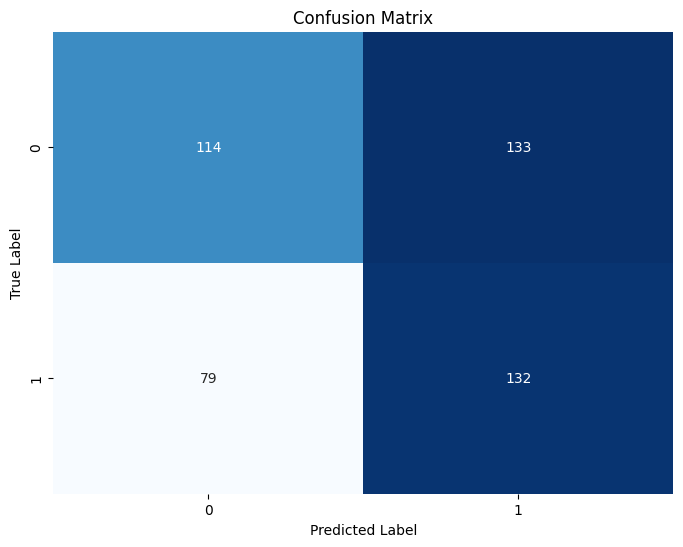

AUC: 0.5619471573574841


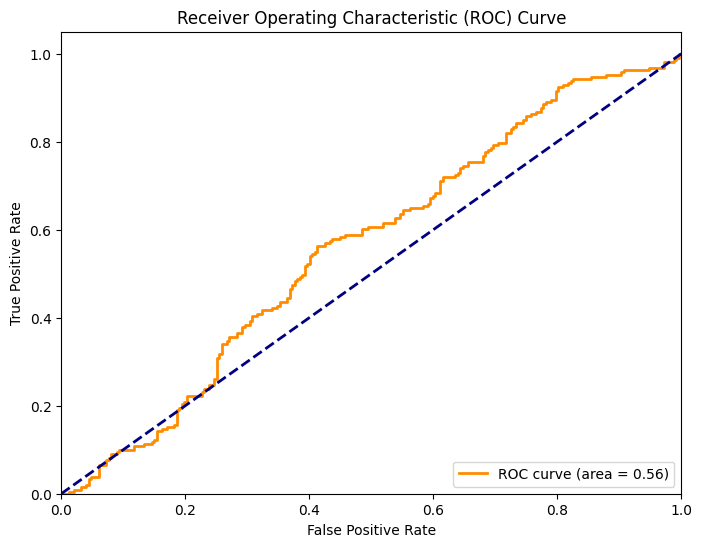

In [ ]:
evaluate_one_class_svm(X_train, y_train, X_test, y_test)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_curve, auc)

def evaluate_one_class_svm_with_loop_and_plots(X_train, y_train, X_test, y_test):
    """
    Trains a OneClassSVM using windowed data processed one window at a time,
    computes metrics, plots the confusion matrix as an image, and plots the ROC curve.

    Parameters:
      X_train (np.array): 3D array for training data (n_samples, window_length, n_features).
      y_train (np.array): Training labels.
      X_test (np.array): 3D array for test data.
      y_test (np.array): True test labels.

    Returns:
      None
    """
    # Process each training window individually to flatten it
    X_train_flat = []
    for window in X_train:
        # Each 'window' is 2D; flatten it to 1D.
        X_train_flat.append(window.flatten())
    X_train_flat = np.array(X_train_flat)
    start_time = time.time()

    # Initialize and train the OneClassSVM
    classifier = svm.OneClassSVM(gamma="auto")
    classifier.fit(X_train_flat, y_train)
    end_time = time.time()
    print("Elapsed time: {:.3f} seconds".format(end_time - start_time))

    # Process test windows individually for prediction and scoring
    y_pred_list = []
    y_scores_list = []
    for window in X_test:
        window_flat = window.flatten().reshape(1, -1)
        # Predict for the current window
        pred = classifier.predict(window_flat)
        y_pred_list.append(pred[0])
        # Get decision function score (used for ROC curve). Higher means more inlier.
        score = classifier.decision_function(window_flat)
        y_scores_list.append(score[0])

    y_pred = np.array(y_pred_list)
    # Convert predictions: inliers (1) become 0, outliers (-1) become 1.
    y_pred_converted = np.where(y_pred == 1, 0, np.where(y_pred == -1, 1, y_pred))

    # Print standard metrics
    print("Test Accuracy:", accuracy_score(y_test, y_pred_converted))
    print("Classification Report:")
    print(classification_report(y_test, y_pred_converted))

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred_converted)
    print("Confusion Matrix:")
    print(cm)

    # Plot the confusion matrix as an image using seaborn heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # Compute ROC curve and AUC.
    # For OneClassSVM, we flip the decision_function scores so that higher scores indicate anomalies.
    y_scores = -np.array(y_scores_list)
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    print("AUC:", roc_auc)

    # Plot the ROC curve.
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()




In [ ]:
evaluate_one_class_svm_with_loop_and_plots(X_train, y_train, X_test, y_test)

# RF

In [ ]:
from sklearn.model_selection import train_test_split

def prepare_train_test_balanced(X, y, torch_used=False, no_anomaly_in_training=False, split_ratio=None, verbose = False):
        """
        Splits the dataset into training and testing sets, balancing the amount of data in both.

        Parameters:
        X (array-like): Features dataset.
        y (array-like): Labels dataset.
        torch_used (bool): If True, converts the datasets to PyTorch tensors.
        no_anomaly_in_training (bool): If True, removes anomalies from training set.

        Returns:
        Training and testing datasets.
        """

        if split_ratio is not None:
            split_ratio = split_ratio

        zeroes = np.where(y == 0)[0]
        ones = np.where(y == 1)[0]

        # Select the smaller of the two classes
        min_class_size = min(len(zeroes), len(ones))

        # Randomly sample the same number from the larger class
        if len(zeroes) < len(ones):
            red_ones = np.random.choice(ones, min_class_size, replace=False)
            X_balanced = np.concatenate([X[zeroes], X[red_ones]])
            y_balanced = np.concatenate([y[zeroes], y[red_ones]])
        else:
            red_zeroes = np.random.choice(zeroes, min_class_size, replace=False)
            X_balanced = np.concatenate([X[ones], X[red_zeroes]])
            y_balanced = np.concatenate([y[ones], y[red_zeroes]])

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, train_size= split_ratio, random_state=42)

        if verbose:
            print(f'Training set shape: {X_train.shape}, {y_train.shape}')
            print(f'Testing set shape: {X_test.shape}, {y_test.shape}')
            print(f'Torch used: {torch_used}')

        if torch_used:
            return (torch.Tensor(X_train), torch.Tensor(y_train),
                    torch.Tensor(X_test), torch.Tensor(y_test))
        return X_train, y_train, X_test, y_test

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
x, y = create_windowed_dataset(df, keep_code = True)

#dovrebbe sistemare il problema della divione su 0
for idx, window in enumerate(x):
  if len(window)==0:
    x.pop(idx)
    y.pop(idx)

#x = np.array(x) # non può funzionare prima di sistemare le dimensioni
x = period_filling2(x)
y = np.array(y)  # Convert y to a NumPy array


Biggest window size:  3912


In [ ]:
X_train, y_train, X_test, y_test = prepare_train_test(x, y,  no_anomaly_in_training=True, split_ratio=0.7, verbose = False)


In [ ]:
X_train, y_train, X_test, y_test = prepare_train_test_balanced(x, y, split_ratio = 0.7, torch_used=False)

In [ ]:
train_x_flat = X_train.reshape(X_train.shape[0], -1)
test_x_flat  = X_test.reshape(X_test.shape[0], -1)

In [ ]:
import time
rf = RandomForestClassifier(n_estimators=200, max_depth=None,
                            min_samples_split=2, random_state=42)
start_time = time.time()
rf.fit(train_x_flat, y_train)
end_time = time.time()

print("Elapsed time: {:.3f} seconds".format(end_time - start_time))

Elapsed time: 59.393 seconds


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, mean_absolute_error, mean_squared_error)
import numpy as np

# Evaluate on the test set:
test_pred = rf.predict(test_x_flat)
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print("Test Classification Report:")
print(classification_report(y_test, test_pred))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, test_pred))

# Calculate NMAE and NRMSE
mae = mean_absolute_error(y_test, test_pred)
rmse = np.sqrt(mean_squared_error(y_test, test_pred))
range_y = np.max(y_test) - np.min(y_test)
if range_y == 0:  # Avoid division by zero if y_test is constant
    range_y = 1
nmae = mae / range_y
nrmse = rmse / range_y

print("NMAE:", nmae)
print("NRMSE:", nrmse)


Test Accuracy: 0.8187772925764192
Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       247
           1       0.76      0.88      0.82       211

    accuracy                           0.82       458
   macro avg       0.82      0.82      0.82       458
weighted avg       0.83      0.82      0.82       458

Test Confusion Matrix:
[[190  57]
 [ 26 185]]
NMAE: 0.1812227074235808
NRMSE: 0.42570260443598507


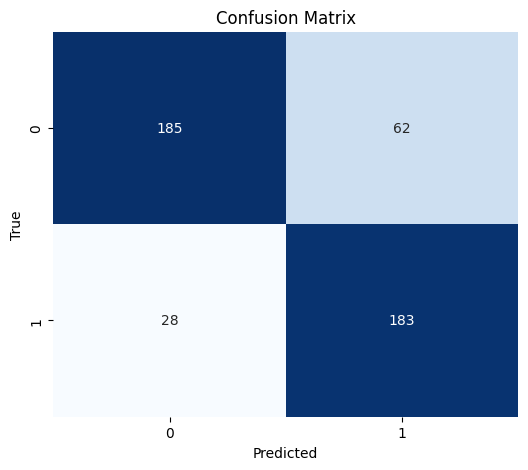

In [ ]:
cm = confusion_matrix(y_test, test_pred)

# Create the heatmap plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'], cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

Test AUROC and AUC: 0.8158470364756222 0.897682138265825


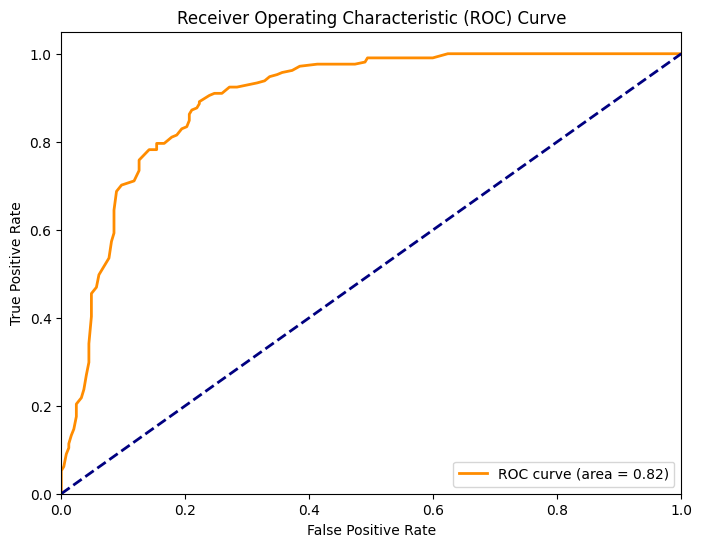

In [ ]:
from sklearn.metrics import  auc, roc_curve, roc_auc_score,  precision_recall_curve

# For ROC curve, obtain the predicted probabilities for the positive class (assumed to be 1):
test_pred_proba = rf.predict_proba(test_x_flat)[:, 1]

# Compute the ROC curve and AUC:
fpr, tpr, thresholds = roc_curve(y_test, test_pred_proba)
auc_value = auc(fpr, tpr)
roc_auc = roc_auc_score(y_test, test_pred)
print("Test AUROC and AUC:", roc_auc, auc_value)

# Plot the ROC curve:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# LSTM

## model

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from abc import ABC, abstractmethod
from torch.utils.data import DataLoader
# crea formato standard .ts
class GeneralModule(nn.Module, ABC):
    def __init__(self, train_dataloader: DataLoader, test_dataloader: DataLoader, validation_dataloader: DataLoader = None,
                loss_function = nn.MSELoss(),
                verbose:bool = False,
                batch_size=64):
        super().__init__()

        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        if validation_dataloader is not None:
            self.validation_dataloader = validation_dataloader
        else:
            self.validation_dataloader = test_dataloader
        self.loss_function = loss_function
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.verbose = verbose
        self.batch_size = batch_size
        if verbose:
            print(f"Using device {self.device}")

    ################
    ### Training and evaluating ##
    ################
    @abstractmethod
    def train_one_epoch(self):
        pass

    @abstractmethod
    def validate_one_epoch(self):
        pass

    @abstractmethod
    def test_model(self):
        pass

In [ ]:

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, mean_squared_error



class UseGeneralModule:
    def __init__(self, train_dataloader: DataLoader, test_dataloader: DataLoader, validation_dataloader: DataLoader = None,
                loss_function = nn.MSELoss(),
                type_optimizer:str = 'adam',
                type_model = 'ae',
                verbose:bool = False,
                learning_rate:float = 0.0005,
                num_epochs:int = 100,
                input_dim_list=[784, 400, 200],
                batch_size=64,
                num_channels = [30] * 4,
                input_size =5,
                kernel_size=3, dropout=0.3, output_size=1,
                hidden_size=1, num_stacked_layers=4,
                bidirectional=False, bias=True,

                ):
        super().__init__()

        self.verbose = verbose
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device {self.device}")
        self.model = self.define_model(type_model=type_model,
            train_dataloader = train_dataloader,
            test_dataloader = test_dataloader,
            loss_function = loss_function,
            verbose = verbose,
            batch_size=batch_size,
            input_dim_list=input_dim_list ,# for AE,
            validation_dataloader=validation_dataloader, # for all
            input_size=input_size, # for TCN
            num_channels=num_channels, # for TCN
            output_size=output_size, # for TCN
            kernel_size=kernel_size, # for TCN
            dropout=dropout, # for TCN
            hidden_size=hidden_size, # for LSTM
            num_stacked_layers=num_stacked_layers, # for LSTM
            bidirectional=bidirectional, # for LSTM
            bias=bias, # for LSTM
        )

        self.num_epochs = num_epochs
        self.learning_rate = learning_rate

        self.optimizer =  self.define_optimizer(type_optimizer=type_optimizer)


    def define_optimizer(self, type_optimizer:str):
        if type_optimizer=='adam':
            return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        elif type_optimizer=='sgd':
            return torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
        elif type_optimizer=='adagrad':
            return torch.optim.Adagrad(self.model.parameters(), lr=self.learning_rate)
        elif type_optimizer=='rmsprop':
            return torch.optim.RMSprop(self.model.parameters(), lr=self.learning_rate)


    def define_model(self, type_model,input_dim_list, train_dataloader,
                test_dataloader, loss_function,
                verbose, batch_size,
                input_size, num_channels,
                validation_dataloader: DataLoader = None,
                kernel_size=3, dropout=0.2, output_size=1,
                hidden_size=1, num_stacked_layers=4,
                bidirectional=False,
                bias=True,
            ):
        if type_model=='lstm':
            return LSTM(
                train_dataloader = train_dataloader,
                test_dataloader = test_dataloader,
                loss_function = loss_function,
                verbose = verbose,
                batch_size=batch_size,
                validation_dataloader=validation_dataloader,
                input_size = input_size,
                hidden_size=hidden_size,
                num_stacked_layers=num_stacked_layers,
                output_size=output_size,
                dropout = dropout
            )
        else:
            return NotImplementedError
    ################
    ### Training and evaluating ##
    ################

    def train_model(self):
        train_losses = []
        val_losses = []
        for epoch in range(self.num_epochs):
            print(f'Epoch: {epoch + 1}')
            train_loss = self.model.train_one_epoch(model =self.model, optimizer=self.optimizer)
            val_loss = self.model.validate_one_epoch(model =self.model)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
        plt.figure(figsize=(10, 5))
        plt.plot(range(self.num_epochs), train_losses, label="Train Loss")
        plt.plot(range(self.num_epochs), val_losses, label="Val Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

    def test_model(self,  threshold=0.5):
        return self.model.test_model(self.model, threshold=threshold)

    def get_model(self) -> nn.Module:
        return self.model



In [ ]:
import torch
import torch.nn as nn
#from ai.torch_lib.GeneralModel import GeneralModule

class LSTM(GeneralModule):
    def __init__(self,  train_dataloader, test_dataloader,
                input_size, loss_function = nn.MSELoss(), validation_dataloader = None,
                verbose:bool = False, output_size = 1, dropout = 0.2,
                batch_size=64, hidden_size=1, num_stacked_layers=4):
        # input size = num of features
        super().__init__(train_dataloader, test_dataloader,validation_dataloader, loss_function, verbose, batch_size)
        self.hidden_size = hidden_size # num di layers tra input e output
        self.num_stacked_layers = num_stacked_layers # model complexity Number of recurrent layers. default 1
        self.input_size = input_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True,dropout = dropout).to(self.device)

        self.fc = nn.Linear(hidden_size, output_size).to(self.device) #Applies a linear transformation to the incoming data 1 è la dimensione dell'output
        #self.activation = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)  # Dynamic batch size
        # Check input dimensions
        if x.size(-1) != self.input_size:
            raise ValueError(f'Expected input size {self.input_size}, got {x.size(-1)}')

        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        #return self.activation(out)
        return out

    ################
    ### Training and evaluating ##
    ################
    def train_one_epoch(self, model, optimizer):
        model.train(True)
        running_loss = 0.0
        for batch_index, (x_batch,  y_batch) in enumerate(self.train_dataloader):
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            if x_batch.dim() == 2:
                raise ValueError((f'Dimension of X_batch == 2 expected == 3'))
            optimizer.zero_grad()
            try:
                output = model(x_batch).to(self.device)
                loss = self.loss_function(output, y_batch) #loss = self.loss_function(output, x_batch)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                if self.verbose and batch_index % self.batch_size == 1:
                    print(f'Batch {batch_index}, Loss: {loss.item()}')

            except RuntimeError as e:
                print(f"Error in batch {batch_index}")
                print(f"Input shape: {x_batch.shape}")
                print(f"Expected input size: {self.input_size}")
                print(f"Output size: {output.shape}")
                raise e
        avg_loss_across_batches = running_loss / len(self.train_dataloader)
        if self.verbose:
            print('Train Loss: {0:.3f}'.format(avg_loss_across_batches))
        return avg_loss_across_batches

    def validate_one_epoch(self, model):
        model.eval() # or model.train(False)
        running_loss = 0.0
        for batch_index, (x_batch,  y_batch) in enumerate(self.validation_dataloader):
            with torch.no_grad(): # no gradiente perché non sto aggiornando il modello
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                output = model(x_batch).to(self.device)
                loss = self.loss_function(output, y_batch)
                running_loss += loss.item()

        avg_loss_across_batches = running_loss / len(self.validation_dataloader)
        if self.verbose:
            print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
        return avg_loss_across_batches

    def test_model(self, model, threshold=0.5):
        # model.eval()
        # preds_list = []
        # with torch.no_grad():
        #     for batch_x, batch_y in self.test_dataloader:
        #         batch_x = batch_x.to(self.device)
        #         batch_y = batch_y.to(self.device)
        #         outputs = model(batch_x)
        #         preds_list.append(outputs.cpu())
        # return preds_list, None
        model.eval()
        preds_list = []
        with torch.no_grad():
            for batch_x, batch_y in self.test_dataloader:
                batch_x = batch_x.to(self.device)
                outputs = model(batch_x).detach().cpu()
                preds_list.append(outputs)
        preds = torch.cat(preds_list).numpy()
        print(preds)
        preds_binary = (preds.flatten() > threshold).astype(int)
        return preds, preds_binary



## run

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

In [ ]:
# =============================================================================
# 2. CONVERT DATAFRAME TO TENSOR SEQUENCES
# =============================================================================
# (Assumes you have a function named split_sequence that returns (x, y) arrays.)
x, y = create_windowed_dataset(df)

#dovrebbe sistemare il problema della divione su 0
for idx, window in enumerate(x):
  if len(window)==0:
    x.pop(idx)
    y.pop(idx)

#x = np.array(x) # non può funzionare prima di sistemare le dimensioni
x = period_filling2(x)
x = torch.from_numpy(x).type(torch.Tensor)
# Rearranging to shape: [num_samples, features, windowSize]
x = x.permute(0, 2, 1)
y = np.array(y)  # Convert y to a NumPy array
y = torch.from_numpy(y).type(torch.Tensor)
# Ensure y has shape [num_samples, 1]
y = y.unsqueeze(1)


total_samples = len(x)
print("Total sequences:", total_samples)

Biggest window size:  3912
Total sequences: 7350


In [ ]:
# After creating x and y
# Ensure y is a list/array of labels and x is a list of windows.
X_anom = []
X_norm = []
for i, lbl in enumerate(y):
    if lbl == 1:
        X_anom.append(x[i])
    else:
        X_norm.append(x[i])

# Then convert to numpy arrays if necessary.
X_anom = np.array(X_anom)
X_norm = np.array(X_norm)
y_anom = np.array([1 for _ in range(len(X_anom))])
y_norm = np.array([0 for _ in range(len(X_norm))])

print("Normal windows: ", len(X_norm))
print("Anomaly windows: ", len(X_anom))


Normal windows:  6588
Anomaly windows:  762


In [ ]:
# =============================================================================
# 3. SPLIT INTO TRAIN, VALIDATION, AND TEST (CONTIGUOUS SPLIT)
# =============================================================================
#X_anom= np.array(X_anom)
#X_norm= np.array(X_norm)
#y_anom= np.array(y_anom)
#y_norm= np.array(y_norm)

# For time series data, we split contiguously.
train_end = int(0.7 * len(X_norm))
val_end   = len(X_norm) - len(X_anom)

train_x = X_norm[:train_end]
train_y = y_norm[:train_end ]
val_x   = X_norm[train_end:val_end]
val_y   = y_norm[train_end:val_end]
test_x = np.concatenate((X_anom, X_norm[val_end:]), axis=0)
test_y = np.concatenate((y_anom, y_norm[val_end:]), axis=0)

#test_x  = X_anom + X_norm[val_end:]
#test_y  = y_anom + y_norm[val_end:]


In [ ]:
train_x = torch.from_numpy(train_x).type(torch.Tensor)
train_y = torch.from_numpy(train_y).type(torch.Tensor)
val_x   = torch.from_numpy(val_x).type(torch.Tensor)
val_y   = torch.from_numpy(val_y).type(torch.Tensor)
test_x  = torch.from_numpy(test_x).type(torch.Tensor)
test_y  = torch.from_numpy(test_y).type(torch.Tensor)

train_y = train_y.unsqueeze(1)
val_y   = val_y.unsqueeze(1)
test_y  = test_y.unsqueeze(1)
train_x = train_x.permute(0, 2, 1)
val_x   = val_x.permute(0, 2, 1)
test_x  = test_x.permute(0, 2, 1)

print("Training samples:", len(train_x))
print("Validation samples:", len(val_x))
print("Test samples:", len(test_x))

Training samples: 4611
Validation samples: 1215
Test samples: 1524


In [ ]:
# =============================================================================
# 4. CREATE DATASETS & DATALOADERS (USING ALL SAMPLES)
# =============================================================================
# In this version, we keep **all** samples in train and validation, including those where y==1.
batch_size = 64  # Adjust based on your GPU capacity

# Since the data is ordered by time, we keep shuffle=False for all splits.
train_dataset = TensorDataset(train_x, train_y)
val_dataset   = TensorDataset(val_x, val_y)
test_dataset  = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [ ]:
input_size = train_x.size(2)  # Number of features
print("Input size:", input_size)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UseGeneralModule(
       train_dataloader=train_loader,
       test_dataloader=test_loader,
       type_model = 'lstm',
       verbose=True,
       validation_dataloader=val_loader,
       hidden_size=3,
       num_stacked_layers=3,
       input_size = train_x.shape[2],
       num_epochs=30,
       batch_size=16,
       learning_rate=0.001,
       output_size = train_y.shape[1]
)

print("Using:", device)
print(model)

Input size: 19
Using device cpu
Using device cpu
Using: cpu


Epoch: 1
Batch 1, Loss: 0.00565322395414114
Batch 17, Loss: 0.0009347063023597002
Batch 33, Loss: 3.2869291317183524e-05
Batch 49, Loss: 3.095646025030874e-05
Batch 65, Loss: 3.746911170310341e-05
Train Loss: 0.001
Val Loss: 0.000
Epoch: 2
Batch 1, Loss: 7.200783875305206e-05
Batch 17, Loss: 7.444853690685704e-05
Batch 33, Loss: 2.6267858629580587e-05
Batch 49, Loss: 2.7931349904974923e-05
Batch 65, Loss: 2.779441638267599e-05
Train Loss: 0.000
Val Loss: 0.000
Epoch: 3
Batch 1, Loss: 4.532706952886656e-05
Batch 17, Loss: 4.3820604332722723e-05
Batch 33, Loss: 1.8716787963057868e-05
Batch 49, Loss: 1.2791163499059621e-05
Batch 65, Loss: 1.6466150555061176e-05
Train Loss: 0.000
Val Loss: 0.000
Epoch: 4
Batch 1, Loss: 3.141637716908008e-05
Batch 17, Loss: 3.2196141546592116e-05
Batch 33, Loss: 1.8540875316830352e-05
Batch 49, Loss: 1.2065345799783245e-05
Batch 65, Loss: 1.589576459082309e-05
Train Loss: 0.000
Val Loss: 0.000
Epoch: 5
Batch 1, Loss: 2.334126656933222e-05
Batch 17, Loss: 2.

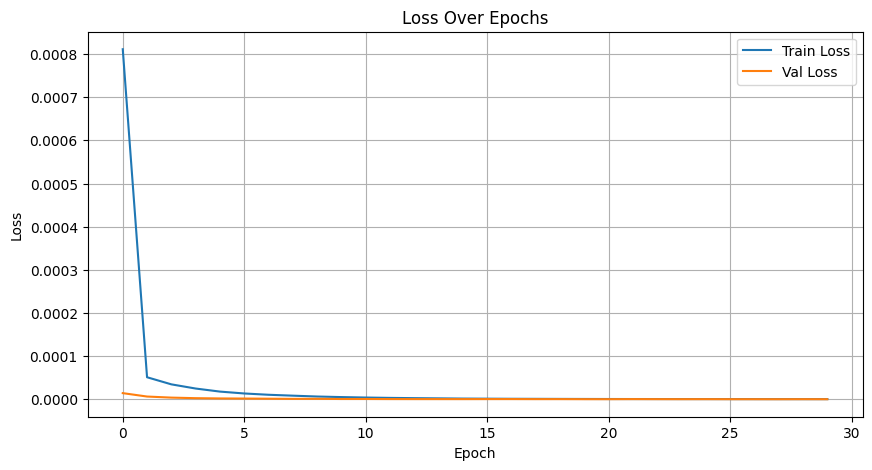

Elapsed time: 1892.476 seconds


In [ ]:
import time
start_time = time.time()

model.train_model()

end_time = time.time()
print("Elapsed time: {:.3f} seconds".format(end_time - start_time))

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score, mean_squared_error, roc_curve, auc, mean_absolute_error)
import numpy as np

def evaluate(model, test_dataloader, threshold=0.5, plot=True, class_names=['0', '1']):
    """
    Evaluate a model on the test dataset.
    Computes accuracy, precision, recall, F1 score, AUC, MSE, NMAE, NRMSE, and plots the confusion matrix.

    Parameters:
        model: The trained model. If it's a wrapper (e.g., UseGeneralModule),
               it should have an attribute `model` which is callable.
        test_dataloader: DataLoader for the test dataset.
        threshold: Cutoff for binary classification (default=0.5).
        plot: Whether to plot the confusion matrix and ROC curve.
        class_names: Labels for the confusion matrix axes (default binary labels).

    Returns:
        A dictionary containing the computed metrics.
    """
    # If the provided model is a wrapper, extract the underlying model.
    if not callable(model) and hasattr(model, "model") and callable(model.model):
        model = model.model

    # Set model to evaluation mode if possible.
    if hasattr(model, 'eval'):
        model.eval()
    else:
        print("Warning: model does not have an eval() method. Proceeding without switching to eval mode.")

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in test_dataloader:
            # If the model has a 'device' attribute, move the data accordingly.
            if hasattr(model, 'device'):
                batch_x = batch_x.to(model.device)
            outputs = model(batch_x)
            all_preds.append(outputs.detach().cpu())
            all_labels.append(batch_y)

    # Concatenate predictions and labels.
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Flatten predictions and apply threshold to get binary outputs.
    all_preds_flat = all_preds.flatten()
    preds_binary = (all_preds_flat > threshold).astype(int)

    # Calculate metrics.
    accuracy = accuracy_score(all_labels, preds_binary)
    precision = precision_score(all_labels, preds_binary, zero_division=0)
    recall = recall_score(all_labels, preds_binary, zero_division=0)
    f1 = f1_score(all_labels, preds_binary, zero_division=0)
    cm = confusion_matrix(all_labels, preds_binary)
    roc_auc_score_value = roc_auc_score(all_labels, all_preds_flat)
    mse = mean_squared_error(all_labels, all_preds_flat)

    # Calculate NMAE and NRMSE.
    mae = mean_absolute_error(all_labels, all_preds_flat)
    rmse = np.sqrt(mean_squared_error(all_labels, all_preds_flat))
    range_y = np.max(all_labels) - np.min(all_labels)
    if range_y == 0:
        range_y = 1
    nmae = mae / range_y
    nrmse = rmse / range_y

    # Print the metrics.
    print("Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print(f"AUC: {roc_auc_score_value:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"NMAE: {nmae:.4f}")
    print(f"NRMSE: {nrmse:.4f}")

    # Plot the confusion matrix as an image.
    if plot:
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    fpr, tpr, thresholds = roc_curve(all_labels, preds_binary, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve.
    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC CURVE')
        plt.legend(loc="lower right")
        plt.show()

    return {
        "gt": all_labels,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm,
        "auc": roc_auc,
        "mse": mse,
        "nmae": nmae,
        "nrmse": nrmse,
        "predictions_binary": preds_binary,  # Binary predictions
        "predictions_raw": all_preds_flat     # Raw probability predictions
    }


Evaluation Metrics:
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[762   0]
 [762   0]]
AUC: 0.2218
MSE: 0.4997
NMAE: 0.5002
NRMSE: 0.7069


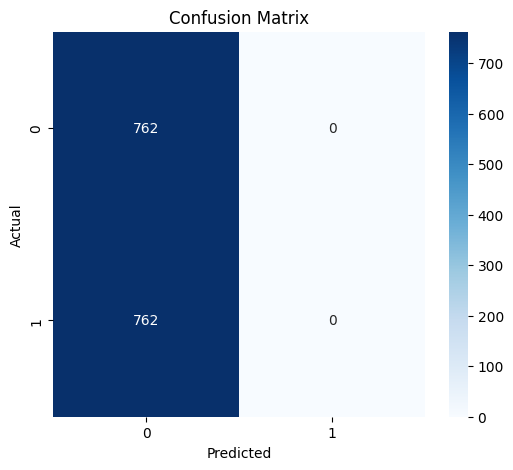

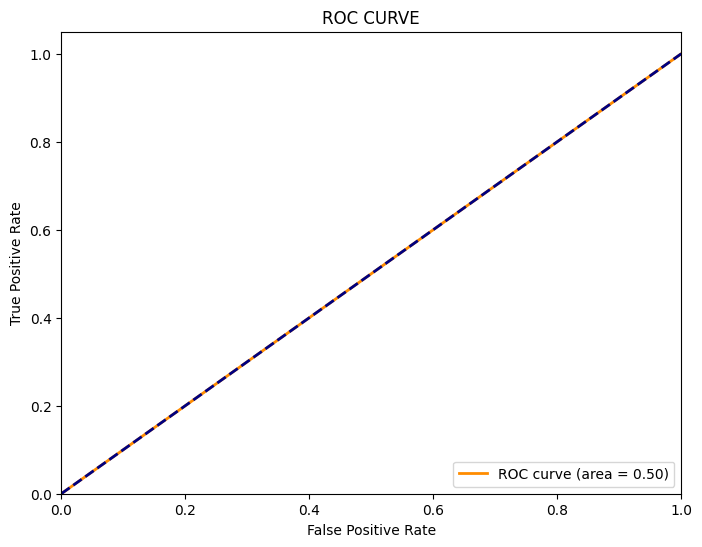

In [ ]:
results = evaluate(model, test_loader, threshold=0.5, plot=True)
binary_predictions = results["predictions_binary"]
raw_predictions = results["predictions_raw"]

In [ ]:
import numpy as np

def find_best_threshold_grid(model, test_dataloader, tol=1e-5, max_iter=20, grid_points=10, low =0.0, high = 1.0):
    """
    Find the threshold that maximizes the combined metric (sum of accuracy, precision, recall, f1, and auc)
    using a grid search based divide-and-conquer approach.

    Parameters:
        model: The trained model (or a wrapper with a callable `model` attribute).
        test_dataloader: DataLoader for the test dataset.
        tol: Tolerance for stopping criterion (search stops when interval width < tol).
        max_iter: Maximum number of iterations.
        grid_points: Number of points in the grid to sample per iteration.

    Returns:
        best_threshold: The threshold value that yielded the best combined metric.
        best_combined_metric: The best combined metric value achieved.
    """
    def combined_metric(metrics):
        # Sum the metrics to maximize. Exclude metrics like mse or confusion_matrix.
        return (metrics["accuracy"] + metrics["precision"]/2 +
                metrics["recall"]/2 + metrics["f1"] + metrics["auc"])

    best_threshold = None
    best_combined_metric = -float('inf')
    i = 0
    for i in range(max_iter):
        # Create a grid of threshold values over the current interval.
        thresholds = np.linspace(low, high, grid_points)
        combined_values = []

        # Evaluate the combined metric at each threshold.
        for t in thresholds:
            metrics = evaluate(model, test_dataloader, threshold=t, plot=False)
            combined_values.append(combined_metric(metrics))

        # Find the best threshold from the grid.
        best_index = np.argmax(combined_values)
        current_best = thresholds[best_index]
        if combined_values[best_index] > best_combined_metric:
            best_combined_metric = combined_values[best_index]
            best_threshold = current_best

        # Narrow the search interval around the best threshold.
        if best_index == 0:
            low, high = thresholds[0], thresholds[1]
        elif best_index == len(thresholds) - 1:
            low, high = thresholds[-2], thresholds[-1]
        else:
            low, high = thresholds[best_index - 1], thresholds[best_index + 1]

        # Break if the interval is small enough.
        if (high - low) < tol:
            break

    return best_threshold, best_combined_metric, i


In [ ]:
np.mean(raw_predictions)


0.00025900372

In [ ]:
adjust_min = np.min(raw_predictions)
adjust_max = np.max(raw_predictions)
adjust_mean = np.mean(raw_predictions)
better_low = adjust_min + (adjust_mean/3)
better_high = adjust_max - (adjust_mean/3)

best_threshold, best_metric, iter = find_best_threshold_grid(model, test_loader, max_iter=2000, grid_points=100,  tol=1e-5, low = better_low, high = better_high)

Evaluation Metrics:
Accuracy: 0.4770
Precision: 0.4882
Recall: 0.9541
F1 Score: 0.6459
Confusion Matrix:
[[  0 762]
 [ 35 727]]
AUC: 0.2218
MSE: 0.4997
NMAE: 0.5002
NRMSE: 0.7069
Evaluation Metrics:
Accuracy: 0.4757
Precision: 0.4876
Recall: 0.9514
F1 Score: 0.6447
Confusion Matrix:
[[  0 762]
 [ 37 725]]
AUC: 0.2218
MSE: 0.4997
NMAE: 0.5002
NRMSE: 0.7069
Evaluation Metrics:
Accuracy: 0.4751
Precision: 0.4872
Recall: 0.9501
F1 Score: 0.6441
Confusion Matrix:
[[  0 762]
 [ 38 724]]
AUC: 0.2218
MSE: 0.4997
NMAE: 0.5002
NRMSE: 0.7069
Evaluation Metrics:
Accuracy: 0.4751
Precision: 0.4872
Recall: 0.9501
F1 Score: 0.6441
Confusion Matrix:
[[  0 762]
 [ 38 724]]
AUC: 0.2218
MSE: 0.4997
NMAE: 0.5002
NRMSE: 0.7069
Evaluation Metrics:
Accuracy: 0.4751
Precision: 0.4872
Recall: 0.9501
F1 Score: 0.6441
Confusion Matrix:
[[  0 762]
 [ 38 724]]
AUC: 0.2218
MSE: 0.4997
NMAE: 0.5002
NRMSE: 0.7069
Evaluation Metrics:
Accuracy: 0.4751
Precision: 0.4872
Recall: 0.9501
F1 Score: 0.6441
Confusion Matrix:


KeyboardInterrupt: 

In [ ]:
print(best_threshold)
results = evaluate(model, test_loader, threshold = best_threshold, plot=True)

# TCN

In [ ]:
#@title model
#https://github.com/locuslab/TCN/blob/master/TCN/tcn.py
import torch
import torch.nn as nn
# Use the new import for weight normalization
from torch.nn.utils.parametrizations import weight_norm

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        # Remove the last `chomp_size` elements in the time dimension
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        # Use the updated weight_norm import here:
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        # If input and output channels differ, use a 1x1 convolution for the residual connection.
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        # Initialize weights for the convolutional layers
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                       padding=(kernel_size - 1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        # x shape: [batch, channels, seq_length]
        y = self.tcn(x)              # y shape: [batch, num_channels[-1], seq_length]
        y = y.transpose(1, 2)        # y shape: [batch, seq_length, num_channels[-1]]
        out = self.linear(y)         # out shape: [batch, seq_length, output_size]
        return out


## run

Biggest window size:  3912
Total sequences: 7350
Normal windows:  6588
Anomaly windows:  762
Training samples: 4611
Validation samples: 1215
Test samples: 1524
Epoch	Train Loss	Val Loss	Val Acc	Val Precision	Val Recall	Val F1
0	0.054797879047	0.068737530835	0.9580	0.0000	0.0000	0.0000
1	0.020677568017	0.011241345568	0.9992	0.0000	0.0000	0.0000
2	0.007098518934	0.010181027509	0.9877	0.0000	0.0000	0.0000
3	0.003239970565	0.002578505987	1.0000	0.0000	0.0000	0.0000
4	0.001778282569	0.002389844700	1.0000	0.0000	0.0000	0.0000
5	0.001169957689	0.001779659159	1.0000	0.0000	0.0000	0.0000
6	0.000956623040	0.001666384683	1.0000	0.0000	0.0000	0.0000
7	0.000578336143	0.001589115055	1.0000	0.0000	0.0000	0.0000
8	0.000509082423	0.001353241849	1.0000	0.0000	0.0000	0.0000
9	0.000537968588	0.001158134825	1.0000	0.0000	0.0000	0.0000


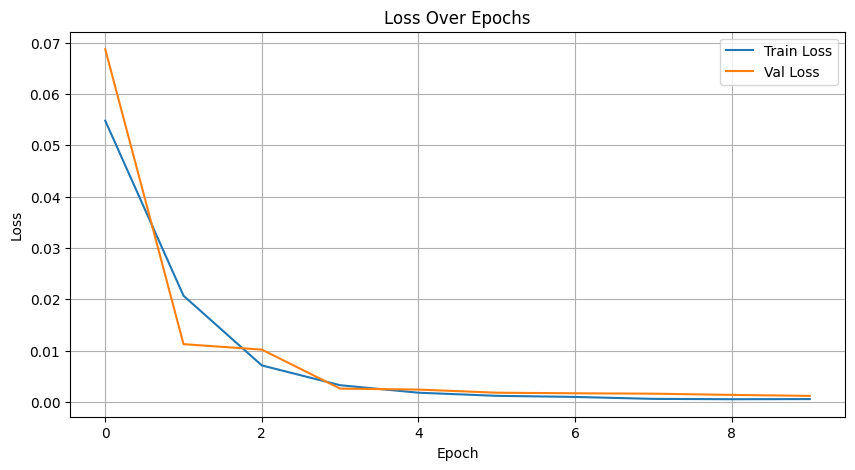

Test Evaluation Metrics:
-------------------------------
Accuracy:  0.49934383202099736
Precision: 0.0
Recall:    0.0
F1 Score:  0.0

Confusion Matrix:
 [[761   1]
 [762   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       762
           1       0.00      0.00      0.00       762

    accuracy                           0.50      1524
   macro avg       0.25      0.50      0.33      1524
weighted avg       0.25      0.50      0.33      1524



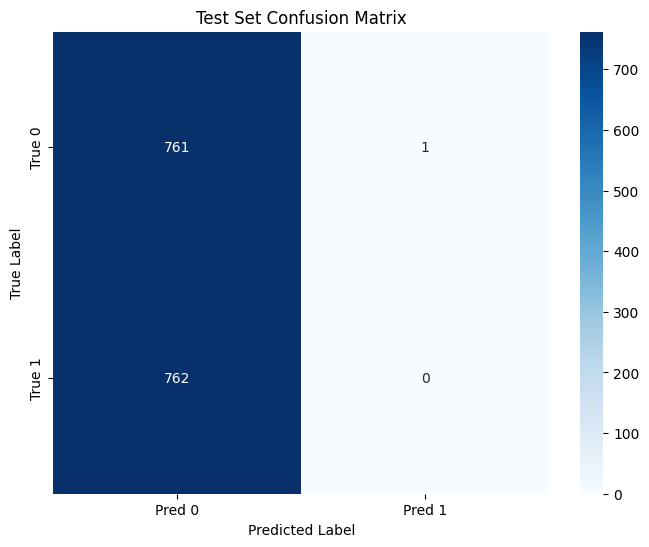

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

# =============================================================================
# 2. CONVERT DATAFRAME TO TENSOR SEQUENCES
# =============================================================================
# (Assumes you have a function named split_sequence that returns (x, y) arrays.)
x, y = create_windowed_dataset(df)

#dovrebbe sistemare il problema della divione su 0
for idx, window in enumerate(x):
  if len(window)==0:
    x.pop(idx)
    y.pop(idx)

#x = np.array(x) # non può funzionare prima di sistemare le dimensioni
x = period_filling2(x)
x = torch.from_numpy(x).type(torch.Tensor)
# Rearranging to shape: [num_samples, features, windowSize]
x = x.permute(0, 2, 1)
y = np.array(y)  # Convert y to a NumPy array
y = torch.from_numpy(y).type(torch.Tensor)
# Ensure y has shape [num_samples, 1]
y = y.unsqueeze(1)


total_samples = len(x)
print("Total sequences:", total_samples)

# After creating x and y
# Ensure y is a list/array of labels and x is a list of windows.
X_anom = []
X_norm = []
for i, lbl in enumerate(y):
    if lbl == 1:
        X_anom.append(x[i])
    else:
        X_norm.append(x[i])

# Then convert to numpy arrays if necessary.
X_anom = np.array(X_anom)
X_norm = np.array(X_norm)
y_anom = np.array([1 for _ in range(len(X_anom))])
y_norm = np.array([0 for _ in range(len(X_norm))])

print("Normal windows: ", len(X_norm))
print("Anomaly windows: ", len(X_anom))
# =============================================================================
# 3. SPLIT INTO TRAIN, VALIDATION, AND TEST (CONTIGUOUS SPLIT)
# =============================================================================
#X_anom= np.array(X_anom)
#X_norm= np.array(X_norm)
#y_anom= np.array(y_anom)
#y_norm= np.array(y_norm)

# For time series data, we split contiguously.
train_end = int(0.7 * len(X_norm))
val_end   = len(X_norm) - len(X_anom)

train_x = X_norm[:train_end]
train_y = y_norm[:train_end ]
val_x   = X_norm[train_end:val_end]
val_y   = y_norm[train_end:val_end]
test_x = np.concatenate((X_anom, X_norm[val_end:]), axis=0)
test_y = np.concatenate((y_anom, y_norm[val_end:]), axis=0)

#test_x  = X_anom + X_norm[val_end:]
#test_y  = y_anom + y_norm[val_end:]
train_x = torch.from_numpy(train_x).type(torch.Tensor)
train_y = torch.from_numpy(train_y).type(torch.Tensor)
val_x   = torch.from_numpy(val_x).type(torch.Tensor)
val_y   = torch.from_numpy(val_y).type(torch.Tensor)
test_x  = torch.from_numpy(test_x).type(torch.Tensor)
test_y  = torch.from_numpy(test_y).type(torch.Tensor)

train_y = train_y.unsqueeze(1)
val_y   = val_y.unsqueeze(1)
test_y  = test_y.unsqueeze(1)
train_x = train_x.permute(0, 2, 1)
val_x   = val_x.permute(0, 2, 1)
test_x  = test_x.permute(0, 2, 1)

print("Training samples:", len(train_x))
print("Validation samples:", len(val_x))
print("Test samples:", len(test_x))

# =============================================================================
# 4. CREATE DATASETS & DATALOADERS (USING ALL SAMPLES)
# =============================================================================
# In this version, we keep **all** samples in train and validation, including those where y==1.
batch_size = 64  # Adjust based on your GPU capacity

# Since the data is ordered by time, we keep shuffle=False for all splits.
train_dataset = TensorDataset(train_x, train_y)
val_dataset   = TensorDataset(val_x, val_y)
test_dataset  = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


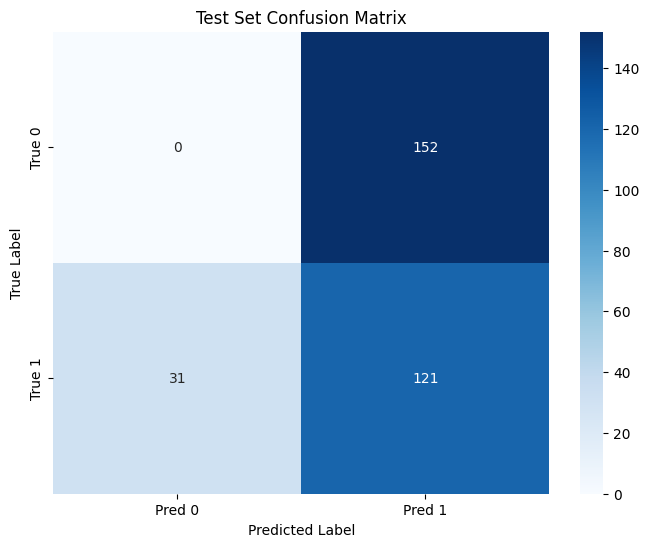

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the confusion matrix
cm_test = np.array([[0, 152],
                    [31, 121]])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Set Confusion Matrix")
plt.show()


In [ ]:
# =============================================================================
# 6. MODEL, OPTIMIZER, AND LOSS SETUP
# =============================================================================
# Assume your TCN model is defined elsewhere.
# If your TCN model is using weight_norm, you can update its import as noted above.
num_channels = [30] * 4
input_size = train_x.size(1)  # Number of features
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TCN(input_size, 1, num_channels, kernel_size=3, dropout=0.3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossFun = nn.MSELoss()

# =============================================================================
# 7. TRAINING FUNCTION WITH VALIDATION PERFORMANCE MONITORING
# =============================================================================
def fit(epochs=10, printEpoch=True):
    train_loss_history = []
    val_loss_history = []
    val_metrics_history = []  # To store (accuracy, precision, recall, f1) per epoch

    if printEpoch:
        header = ("Epoch\tTrain Loss\tVal Loss\tVal Acc\tVal Precision\tVal Recall\tVal F1")
        print(header)

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        running_train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)         # Expected shape: [batch_size, seq_len, 1]
            outputs = outputs[:, -1, :]        # Use the last time step: [batch_size, 1]
            loss = lossFun(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
        avg_train_loss = running_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        preds_list = []
        targets_list = []
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                outputs_val = model(batch_x)
                outputs_val = outputs_val[:, -1, :]
                loss_val = lossFun(outputs_val, batch_y)
                running_val_loss += loss_val.item()
                preds_list.append(outputs_val.cpu())
                targets_list.append(batch_y.cpu())
        avg_val_loss = running_val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)

        preds_val = torch.cat(preds_list).numpy()
        targets_val = torch.cat(targets_list).numpy()
        preds_binary = (preds_val > 0.5).astype(int)
        targets_binary = targets_val.astype(int)
        accuracy_val  = accuracy_score(targets_binary, preds_binary)
        precision_val = precision_score(targets_binary, preds_binary, zero_division=0)
        recall_val    = recall_score(targets_binary, preds_binary, zero_division=0)
        f1_val        = f1_score(targets_binary, preds_binary, zero_division=0)
        val_metrics_history.append((accuracy_val, precision_val, recall_val, f1_val))

        if printEpoch:
            print(f"{epoch}\t{avg_train_loss:.12f}\t{avg_val_loss:.12f}\t"
                  f"{accuracy_val:.4f}\t{precision_val:.4f}\t{recall_val:.4f}\t{f1_val:.4f}")

    return train_loss_history, val_loss_history, val_metrics_history

# Train the model for 10 epochs


Epoch	Train Loss	Val Loss	Val Acc	Val Precision	Val Recall	Val F1
0	0.034956575304	0.086797132990	0.8979	0.0000	0.0000	0.0000
1	0.020886564705	0.096922546417	1.0000	0.0000	0.0000	0.0000
2	0.006970825780	0.005325778975	1.0000	0.0000	0.0000	0.0000
3	0.002077919744	0.000641927841	1.0000	0.0000	0.0000	0.0000
4	0.000512149827	0.000263845016	1.0000	0.0000	0.0000	0.0000
5	0.000267522497	0.000237156085	1.0000	0.0000	0.0000	0.0000
6	0.000150309494	0.000184633459	1.0000	0.0000	0.0000	0.0000
7	0.000115786250	0.000150265332	1.0000	0.0000	0.0000	0.0000
8	0.000089738154	0.000125723930	1.0000	0.0000	0.0000	0.0000
9	0.000077837597	0.000103551452	1.0000	0.0000	0.0000	0.0000
10	0.000058141038	0.000081332337	1.0000	0.0000	0.0000	0.0000
11	0.000051046954	0.000069402419	1.0000	0.0000	0.0000	0.0000
12	0.000039469740	0.000056826712	1.0000	0.0000	0.0000	0.0000
13	0.000030170239	0.000048606534	1.0000	0.0000	0.0000	0.0000
14	0.000024170169	0.000041652144	1.0000	0.0000	0.0000	0.0000
15	0.000021300286	0.000031614

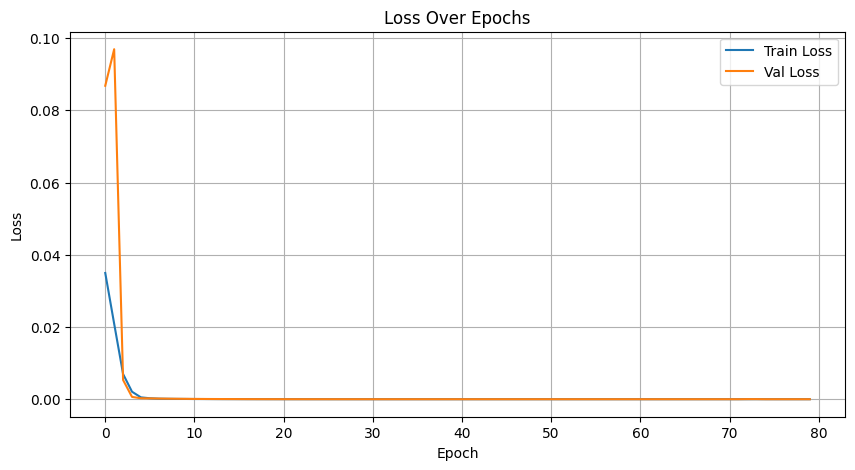

Test Evaluation Metrics:
-------------------------------
Accuracy:  0.5
Precision: 0.0
Recall:    0.0
F1 Score:  0.0

Confusion Matrix:
 [[762   0]
 [762   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       762
           1       0.00      0.00      0.00       762

    accuracy                           0.50      1524
   macro avg       0.25      0.50      0.33      1524
weighted avg       0.25      0.50      0.33      1524



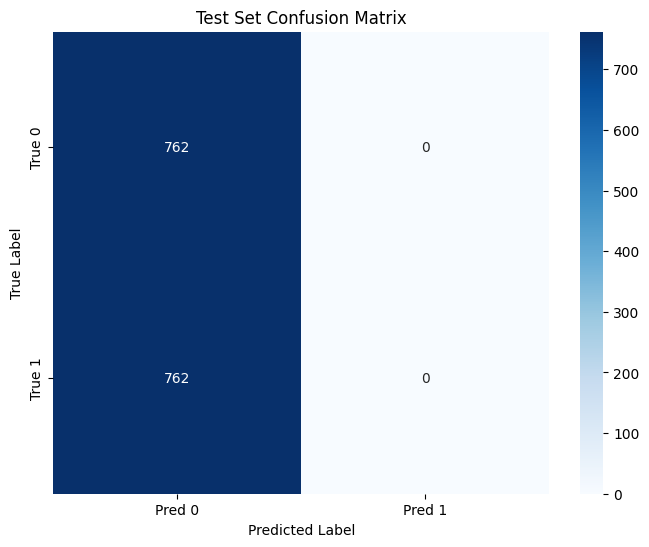

In [ ]:
epochs = 80
import time
start_time = time.time()
train_losses, val_losses, val_metrics = fit(epochs, printEpoch=True)
end_time = time.time()
print("Elapsed time: {:.3f} seconds".format(end_time - start_time))

# Plot training and validation loss history
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses, label="Train Loss")
plt.plot(range(epochs), val_losses, label="Val Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# =============================================================================
# 8. FINAL EVALUATION ON THE TEST SET
# =============================================================================
def evaluate(model, dataloader, threshold=0.5):
    model.eval()
    preds_list = []
    targets_list = []
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_x)
            outputs = outputs[:, -1, :]
            preds_list.append(outputs.cpu())
            targets_list.append(batch_y.cpu())
    preds = torch.cat(preds_list).numpy()
    targets = torch.cat(targets_list).numpy()

    preds_binary = (preds > threshold).astype(int)
    targets_binary = targets.astype(int)

    accuracy  = accuracy_score(targets_binary, preds_binary)
    precision = precision_score(targets_binary, preds_binary, zero_division=0)
    recall    = recall_score(targets_binary, preds_binary, zero_division=0)
    f1        = f1_score(targets_binary, preds_binary, zero_division=0)
    cm        = confusion_matrix(targets_binary, preds_binary)
    report    = classification_report(targets_binary, preds_binary, zero_division=0)

    print("Test Evaluation Metrics:")
    print("-------------------------------")
    print("Accuracy: ", accuracy)
    print("Precision:", precision)
    print("Recall:   ", recall)
    print("F1 Score: ", f1)
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", report)

    return preds_binary, targets_binary, cm

preds_test, targets_test, cm_test = evaluate(model, test_loader)

# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Set Confusion Matrix")
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

def find_best_threshold_grid_TCN(model, test_dataloader, tol=1e-5, max_iter=20, grid_points=10, low =0.0, high = 1.0):
    """
    Find the threshold that maximizes the combined metric (sum of accuracy, precision, recall, f1, and auc)
    using a grid search based divide-and-conquer approach.

    Parameters:
        model: The trained model (or a wrapper with a callable `model` attribute).
        test_dataloader: DataLoader for the test dataset.
        tol: Tolerance for stopping criterion (search stops when interval width < tol).
        max_iter: Maximum number of iterations.
        grid_points: Number of points in the grid to sample per iteration.

    Returns:
        best_threshold: The threshold value that yielded the best combined metric.
        best_combined_metric: The best combined metric value achieved.
    """
    def combined_metric(metrics):
        # Sum the metrics to maximize. Exclude metrics like mse or confusion_matrix.
        return (metrics["accuracy"] + metrics["precision"]/2 +
                metrics["recall"]/2 + metrics["f1"] + metrics["auc"])

    best_threshold = None
    best_combined_metric = -float('inf')
    i = 0
    for i in range(max_iter):
        # Create a grid of threshold values over the current interval.
        thresholds = np.linspace(low, high, grid_points)
        combined_values = []

        # Evaluate the combined metric at each threshold.
        for t in thresholds:
            metrics = evaluate2(model, test_dataloader, threshold=t, plot = False)
            combined_values.append(combined_metric(metrics))

        # Find the best threshold from the grid.
        best_index = np.argmax(combined_values)
        current_best = thresholds[best_index]
        if combined_values[best_index] > best_combined_metric:
            best_combined_metric = combined_values[best_index]
            best_threshold = current_best

        # Narrow the search interval around the best threshold.
        if best_index == 0:
            low, high = thresholds[0], thresholds[1]
        elif best_index == len(thresholds) - 1:
            low, high = thresholds[-2], thresholds[-1]
        else:
            low, high = thresholds[best_index - 1], thresholds[best_index + 1]

        # Break if the interval is small enough.
        if (high - low) < tol:
            break

    return best_threshold, best_combined_metric, i

def evaluate2(model, dataloader, threshold=0.5, plot=False):
    model.eval()
    preds_list = []
    targets_list = []
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_x)
            outputs = outputs[:, -1, :]
            preds_list.append(outputs.cpu())
            targets_list.append(batch_y.cpu())
    preds = torch.cat(preds_list).numpy()
    targets = torch.cat(targets_list).numpy()

    preds_binary = (preds > threshold).astype(int)
    targets_binary = targets.astype(int)

    accuracy  = accuracy_score(targets_binary, preds_binary)
    precision = precision_score(targets_binary, preds_binary, zero_division=0)
    recall    = recall_score(targets_binary, preds_binary, zero_division=0)
    f1        = f1_score(targets_binary, preds_binary, zero_division=0)
    cm        = confusion_matrix(targets_binary, preds_binary)
    report    = classification_report(targets_binary, preds_binary, zero_division=0)
    fpr, tpr, thresholds = roc_curve(targets_binary, preds_binary, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC CURVE')
        plt.legend(loc="lower right")
        plt.show()

    result_ = evaluate_predictions(targets_binary, preds, normalize_by='range', plot = plot)
    print("Normalized MAE:", result_ ["NMAE"])
    print("Normalized RMSE:", result_ ["NRMSE"])

    print("Test Evaluation Metrics:")
    print("-------------------------------")
    print("Accuracy: ", accuracy)
    print("Precision:", precision)
    print("Recall:   ", recall)
    print("F1 Score: ", f1)
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", report)

    '''if plot:
        # Plot the confusion matrix for the test set
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Pred 0", "Pred 1"],
                    yticklabels=["True 0", "True 1"])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Test Set Confusion Matrix")
        plt.show()'''

    return {
        "gt": targets_binary,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm,
        "auc": roc_auc,
        "predictions_binary": preds_binary,  # Binary predictions
        "predictions_raw": preds     # Raw probability predictions
    }

In [ ]:
results__ = evaluate2(model, test_loader, threshold=0.5)
binary_predictions = results__["predictions_binary"]
raw_predictions = results__["predictions_raw"]

Normalized MAE: 0.5000216960906982
Normalized RMSE: 0.7071101107797407
Test Evaluation Metrics:
-------------------------------
Accuracy:  0.5
Precision: 0.0
Recall:    0.0
F1 Score:  0.0

Confusion Matrix:
 [[762   0]
 [762   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       762
           1       0.00      0.00      0.00       762

    accuracy                           0.50      1524
   macro avg       0.25      0.50      0.33      1524
weighted avg       0.25      0.50      0.33      1524



In [ ]:
raw_predictions = results__["predictions_raw"]
print(np.mean(raw_predictions))

-1.4443376e-05


In [ ]:
adjust_min = np.min(raw_predictions)
adjust_max = np.max(raw_predictions)
adjust_mean = np.mean(raw_predictions)
better_low = adjust_min + (adjust_mean/3)
better_high = adjust_max - (adjust_mean/3)

In [ ]:
best_threshold, best_metric, iter = find_best_threshold_grid_TCN(model, test_loader, max_iter=2000, grid_points=100,  tol=1e-6, low = better_low, high = better_high)

Normalized MAE: 0.5000216960906982
Normalized RMSE: 0.7071101107797407
Test Evaluation Metrics:
-------------------------------
Accuracy:  0.5
Precision: 0.5
Recall:    1.0
F1 Score:  0.6666666666666666

Confusion Matrix:
 [[  0 762]
 [  0 762]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       762
           1       0.50      1.00      0.67       762

    accuracy                           0.50      1524
   macro avg       0.25      0.50      0.33      1524
weighted avg       0.25      0.50      0.33      1524

Normalized MAE: 0.5000216960906982
Normalized RMSE: 0.7071101107797407
Test Evaluation Metrics:
-------------------------------
Accuracy:  0.5006561679790026
Precision: 0.5003282994090611
Recall:    1.0
F1 Score:  0.6669584245076586

Confusion Matrix:
 [[  1 761]
 [  0 762]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00   

-1.2813618165133106e-05


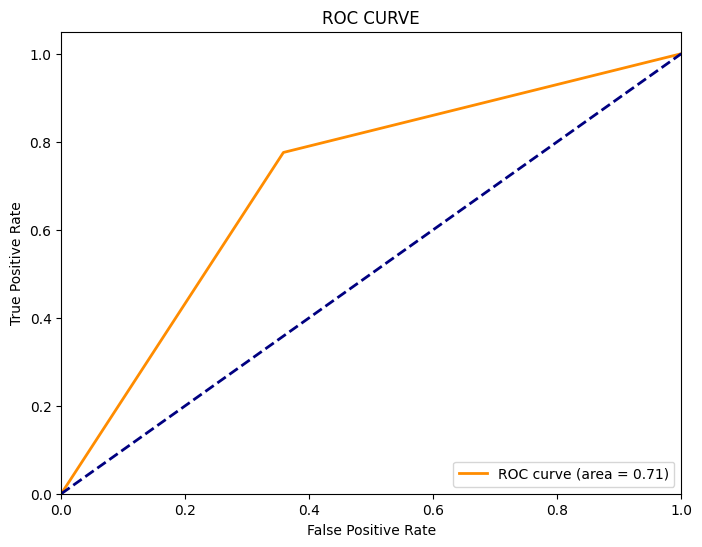

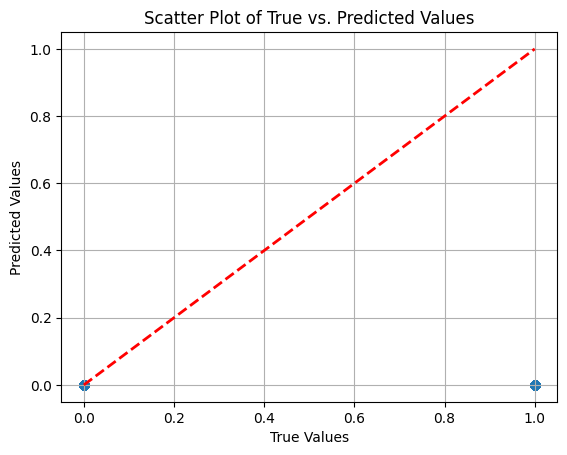

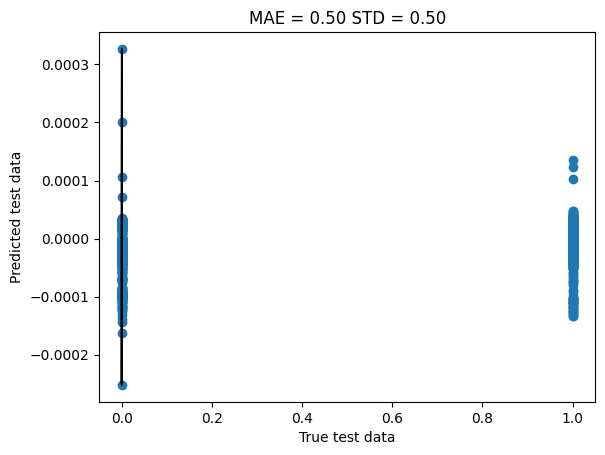

Normalized MAE: 0.5000216960906982
Normalized RMSE: 0.7071101107797407
Test Evaluation Metrics:
-------------------------------
Accuracy:  0.7086614173228346
Precision: 0.6840277777777778
Recall:    0.7755905511811023
F1 Score:  0.7269372693726938

Confusion Matrix:
 [[489 273]
 [171 591]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.64      0.69       762
           1       0.68      0.78      0.73       762

    accuracy                           0.71      1524
   macro avg       0.71      0.71      0.71      1524
weighted avg       0.71      0.71      0.71      1524



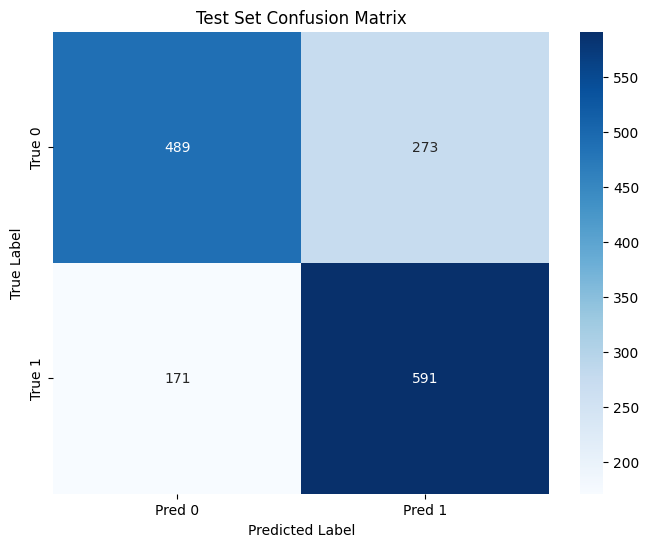

In [ ]:
print(best_threshold)
results_TCN_best = evaluate2(model, test_loader, threshold = best_threshold, plot =True)
cm_test = results_TCN_best["confusion_matrix"]
# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Set Confusion Matrix")
plt.show()

In [ ]:
# Plot a scatter plot of the true test data against the predicted values.
# - The scatter plot shows the relationship between the actual values and the predicted values.
# - The title of the plot displays the Standard Deviation and the Mean Absolute Error (MAE).
real = results_TCN_best["gt"]
pred = results_TCN_best["predictions_raw"]

def evaluate_predictions(y_true, y_pred, normalize_by='range', plot=True):
    """
    Calculate normalized MAE (NMAE) and normalized RMSE (NRMSE) and display a scatter plot
    comparing the normalized true values (real points) with the normalized predictions.

    Parameters:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.
        normalize_by (str): Method of normalization; supports:
                            - 'range': uses (max - min) of y_true to normalize.
                            - 'mean': uses mean of y_true to normalize.
        plot (bool): If True, creates a scatter plot of normalized true vs. normalized predicted values.

    Returns:
        dict: A dictionary containing:
            - 'NMAE': Normalized Mean Absolute Error.
            - 'NRMSE': Normalized Root Mean Squared Error.
    """
    # Calculate errors.
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    # Determine normalization factor.

    norm_factor = np.max(y_true) - np.min(y_true)
    #y_true_norm = y_true  / norm_factor
    y_pred_norm = y_pred  / norm_factor


    # Calculate normalized metrics.
    nmae = mae / norm_factor
    nrmse = rmse / norm_factor

    if plot:
        plt.scatter(y_true, y_pred_norm, alpha=0.6, edgecolors='k')
        plt.plot(y_true, y_true, 'k-')
        plt.xlabel('Normalized True Values')
        plt.ylabel('Normalized Predicted Values')
        plt.title('Scatter Plot of Normalized True vs. Predicted Values')
        # The diagonal line represents a perfect prediction (i.e., y=x).
        plt.plot( color='red', linestyle='--', lw=2)
        plt.grid(True)
        plt.show()

    return {"NMAE": nmae, "NRMSE": nrmse}

In [ ]:
print(pred)

[[ 1.1077667e-06]
 [ 3.1254417e-06]
 [-6.5869926e-08]
 ...
 [ 5.0892481e-08]
 [-1.0282633e-08]
 [ 8.3901341e-08]]


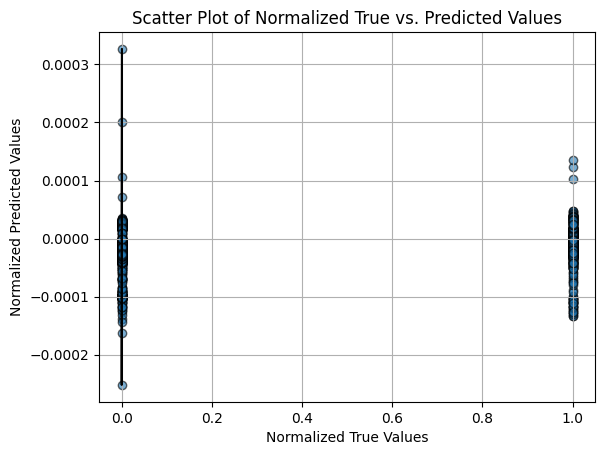

{'NMAE': 0.5000216960906982, 'NRMSE': 0.7071101107797407}

In [ ]:
real = results_TCN_best["gt"]
pred = results_TCN_best["predictions_raw"]
pred_b = results_TCN_best["predictions_binary"]

evaluate_predictions(real, pred, normalize_by='range', plot=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_predictions(y_true, y_pred, normalize_by='range', plot=True):
    """
    Calculate normalized MAE (NMAE) and normalized RMSE (NRMSE) and display a scatter plot
    comparing the normalized true values (real points) with the normalized predictions.

    Parameters:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.
        normalize_by (str): Method of normalization; supports:
                            - 'range': uses (max - min) of y_true to normalize.
                            - 'mean': uses mean of y_true to normalize.
        plot (bool): If True, creates a scatter plot of normalized true vs. normalized predicted values.

    Returns:
        dict: A dictionary containing:
            - 'NMAE': Normalized Mean Absolute Error.
            - 'NRMSE': Normalized Root Mean Squared Error.
    """
    # Calculate errors.
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    # Determine normalization factor.
    if normalize_by == 'range':
        norm_factor = np.max(y_true) - np.min(y_true)
        # For plotting, normalize using min and range so that values are in [0,1]
        y_true_norm = (y_true - np.min(y_true)) / norm_factor
        y_pred_norm = (y_pred - np.min(y_true)) / norm_factor
    elif normalize_by == 'mean':
        norm_factor = np.mean(y_true)
        y_true_norm = y_true / norm_factor
        y_pred_norm = y_pred / norm_factor
    else:
        raise ValueError("Unsupported normalization method. Use 'range' or 'mean'.")

    # Calculate normalized metrics.
    nmae = mae / norm_factor
    nrmse = rmse / norm_factor

    if plot:
        min_ = np.min(pred)
        max_ = np.max(pred)
        plt.scatter(y_true, y_pred_norm, alpha=0.6, edgecolors='k')
        plt.xlabel('Normalized True Values')
        plt.ylabel('Normalized Predicted Values')
        plt.title('Scatter Plot of Normalized True vs. Predicted Values')
        # The diagonal line represents a perfect prediction (i.e., y=x).
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
        plt.grid(True)
        plt.show()

    return {"NMAE": nmae, "NRMSE": nrmse}


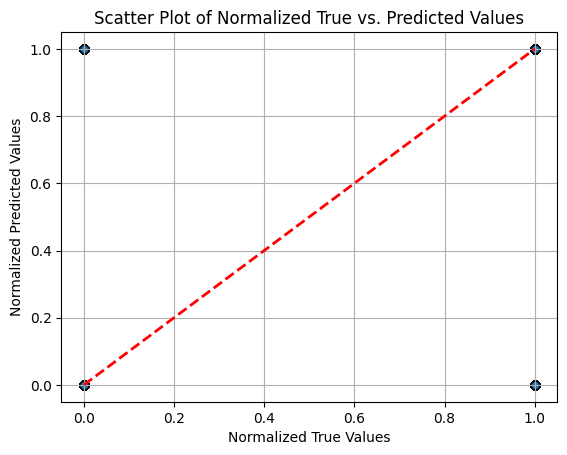

Normalized MAE: 0.29133858267716534
Normalized RMSE: 0.5397578926492556


In [ ]:
results = evaluate_predictions(real, pred_b, normalize_by='range', plot=True)
print("Normalized MAE:", results["NMAE"])
print("Normalized RMSE:", results["NRMSE"])

In [ ]:
def evaluate_plot_mae(real, pred):
        # Plot a scatter plot of the true test data against the predicted values.
        # - The scatter plot shows the relationship between the actual values and the predicted values.
        # - The title of the plot displays the Standard Deviation and the Mean Absolute Error (MAE).
        plt.scatter(real, pred)
        mae = np.abs(real - pred).mean()
        rmse = np.sqrt(mean_squared_error(real, pred))
        sd = np.std(real - pred)
        fact = np.max(real) - np.min(real)
        nmae = mean_absolute_error(real, pred) / fact
        plt.title(
            r"MAE = %.2f" % (mae) +
            r" STD = %.2f" % sd +
            r" RMSE = %.2f" % rmse +
            r" NMAE = %.2f" % nmae
        )

        # Plot a reference line where predicted values equal true values (y = x).
        # This line helps to visualize how well the predicted values match the true values.
        plt.plot(real, real, 'k-')

        # Label the x-axis as 'True test data' and the y-axis as 'Predicted test data'.
        plt.xlabel('True test data')
        plt.ylabel('Predicted test data')

        # Display the plot to the user.
        return plt.show(), mae, rmse, sd, nmae

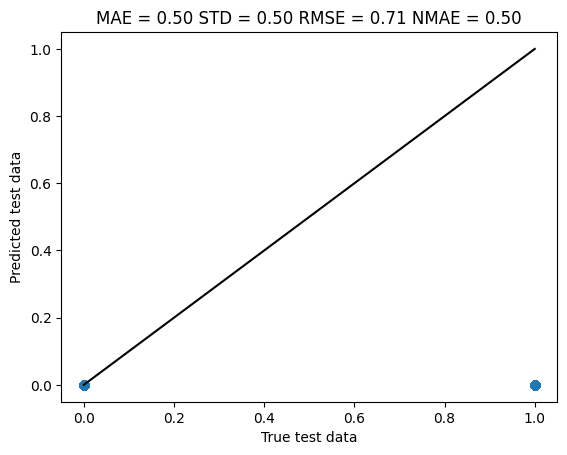

(None,
 0.500021670044128,
 0.7071101107797407,
 0.4999902405229335,
 0.5000216960906982)

In [ ]:
evaluate_plot_mae(real, pred)